**A partir d'un ensemble de données contenant environ dix ans d'observations météorologiques quotidiennes provenant de nombreux endroits en Australie l'objectif est de prédire la variable cible : 'RainTomorrow'. Elle signifie : a-t-il plu le jour suivant, oui ou non ? Cette colonne est 'Oui' si la pluie pour ce jour était de 1 mm ou plus.**


**L'analyse préliminaire des données et leur visualisation ont été présentées dans le fichier '1 Analyse_Exploratoire_DataViz'.**


**Ce fichier présente la recherche de corrélations, la partie feature engineering et les modélisations.**



# **1 Importation des bibliothèques**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import metrics 
from sklearn.metrics import classification_report

from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import f1_score

# **2 Importation du dataset**

In [2]:
df = pd.read_excel('dataset.xlsx', index_col=0)


In [3]:
df.head()


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,No,No,12,2008,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,No,No,12,2008,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,No,No,12,2008,3
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1012.8,NaN,NaN,18.1,26.5,No,No,12,2008,4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,No,No,12,2008,5


# **3 Recherche de corrélations**

##  **Influence de la variable 'RainToday' sur la cible 'RainTomorrow'**

In [4]:
np.round(100 * pd.crosstab(df['RainTomorrow'] , df['RainToday'], normalize = 'columns'),0)


RainToday,No,Yes
RainTomorrow,,
No,85.0,54.0
Yes,15.0,46.0


**La variable 'RainTomorrow' semble fortement corrélée positivement à la variable 'RainToday'.**

**En effet, si il pleut un jour donné, dans 46 % des cas il pleut le lendemain, mais si il ne pleut pas un jour donné alors dans seulement 15 % des cas il pleut le lendemain.**

## **Influence des variables numériques sur la cible 'RainTomorrow'**

**Les données vont être triées dans 2 dataframes selon qu'il pleuve le lendemain ou non.**

**Ainsi en représentant sur un même graphique la fonction de densité de probabilité de chaque variable numérique de ces deux dataframes, on pourra visualiser l'influence de chaque variable sur la cible. Si les 2 courbes sont très différentes ou décalées, cela signifie que la variable a de l'importance pour prévoir la pluie du lendemain.**


In [5]:
# Création de 2 dataframes : il pleut demain OUI/NON 

df_No = df[df['RainTomorrow']=='No']
df_Yes = df[df['RainTomorrow']=='Yes']
df_Yes.shape , df_No.shape


((31201, 25), (109586, 25))


 Les variables numériques sont : 

 ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Month', 'Year', 'Day'] 

 Il y en a : 19  



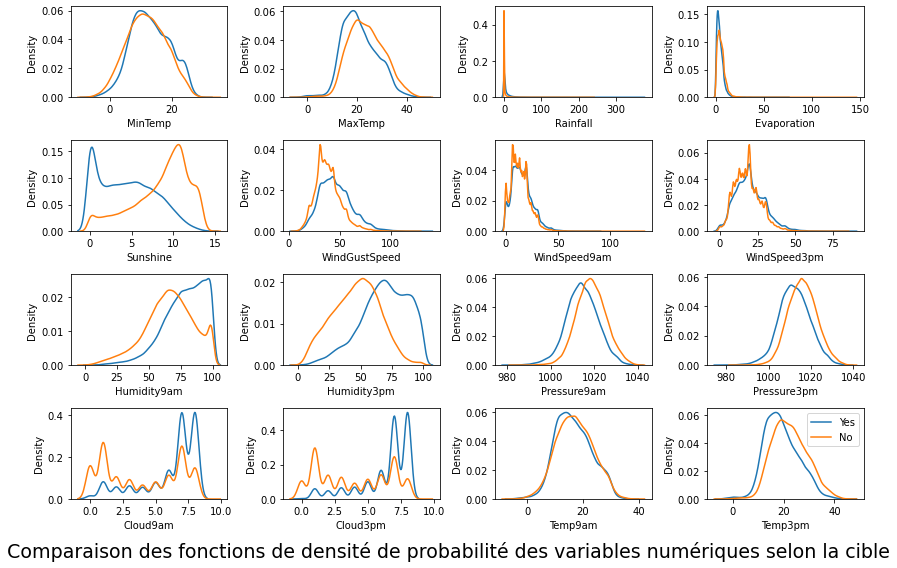

In [6]:
# liste des variables numériques

num = [var for var in df.columns if df[var].dtype != 'object']
print("\n Les variables numériques sont : \n\n", num, '\n\n Il y en a :',len(num),' \n')

# affichage des fonctions de densité de probabilité des variables numériques (sauf date)

fig,axes = plt.subplots(4,4, figsize=(12,8))
fig.suptitle('Comparaison des fonctions de densité de probabilité des variables numériques selon la cible', y=0, size=19)
k=0

for i in range(4) :
  for j in range(4) :
    sns.kdeplot(df_Yes[num[k]], label = 'Yes', ax=axes[i,j])
    sns.kdeplot(df_No[num[k]],  label = 'No', ax=axes[i,j])
    k+=1
    
plt.legend()    
plt.tight_layout();


**En observant ces graphiques il apparait que les variables ‘MaxTemp’, 'Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', et 'Temp3pm' semblent les plus corrélées avec la cible ‘RainTomorrow’.**

## **Influence des variables catégorielles sur la cible 'RainTomorrow'**

In [7]:
# liste des variables catégorielles

cat = [var for var in df.columns if df[var].dtype == 'object']
print("\n Les variables catégrorielles sont : \n\n", cat, '\n\n Il y en a :',len(cat),' \n')



 Les variables catégrorielles sont : 

 ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'] 

 Il y en a : 6  



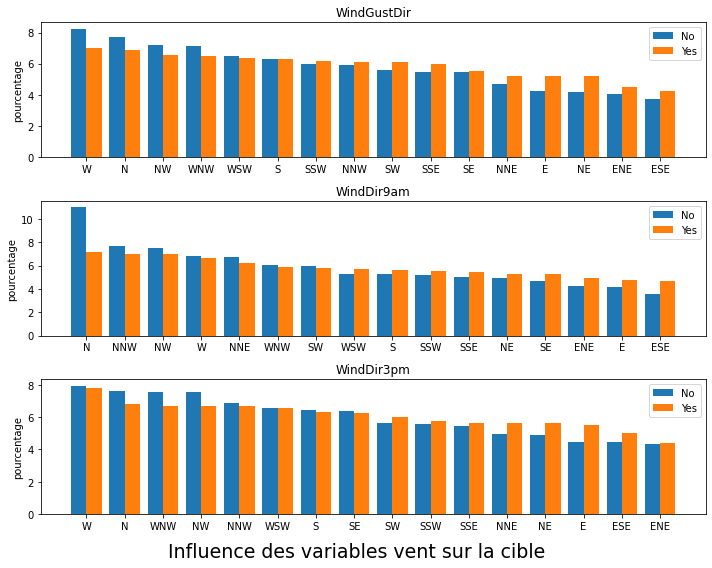

In [8]:
L = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

k=0

plt.figure(figsize=(10,8))

for i in range(1,4) :

  labels = list(df_Yes[L[k]].value_counts().index)
  x = np.arange(len(labels)) 

  No = df_No[L[k]].value_counts()/len(df_No)*100
  Yes = df_Yes[L[k]].value_counts()/len(df_Yes)*100

  plt.subplot(3,1,i)
  plt.bar(x - 0.2, Yes, label='No', width=0.4)
  plt.bar(x + 0.2, No, label='Yes', width=0.4)
  plt.ylabel('pourcentage')
  plt.xticks(x,labels)
  plt.title(L[k])
  k+=1

  plt.legend()

plt.suptitle('Influence des variables vent sur la cible',y=0, size=19)
plt.tight_layout()
plt.show()


**Globalement sur le territoire australien, lorsque le vent est orienté Est, il est plus probable qu’il pleuve le lendemain mais si le vent est orienté Ouest ou Nord, il est moins probable qu’il pleuve le lendemain.**

## **Matrice de corrélation**

**Avant d'afficher la matrice de corrélation du jeu de données nous transformation les variables catégorielles 'RainTomorrow' 'et 'RainToday' OUI, NON en variables numériques 1, 0 afin que ces variables apparaissent dans la matrice de corrélation.**


In [9]:
df['RainTomorrow']=df['RainTomorrow'].replace(['No','Yes'],[0,1])
df['RainToday']=df['RainToday'].replace(['No','Yes'],[0,1])


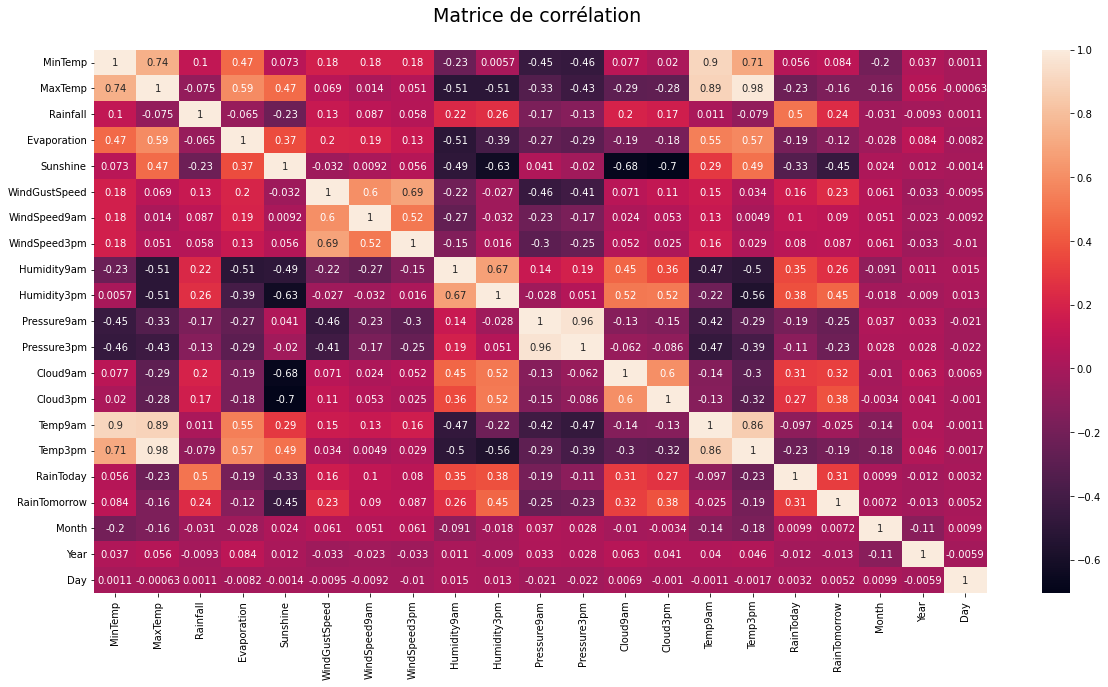

In [10]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True)
plt.title('Matrice de corrélation \n', size=19);


**Les variables 'Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp3pm' et 'RainToday' sont les plus importantes en terme de corrélation avec la cible 'RainTomorrow'.**


# **4 Transformation des variables catégorielles en variables numériques**

In [11]:
# mise à jour de la liste des variables catégorielles

cat = [var for var in df.columns if df[var].dtype == 'object']
print('il reste ',len(cat),'variables catégorielles :', cat)


il reste  4 variables catégorielles : ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


**Les variables 'WindGustDir', 'WindDir9am', 'WindDir3pm' sont des variables circulaires (à 16 modalités : les point cardinaux). En effet ceux sont ici des variables qualitatives  qui bouclent sur elles-même :**

**'E', 'ENE', 'NE','NNE', 'N', 'NNW', 'NW', 'WNW','W', 'WSW', 'SW','SSW', 'S', 'SSE', 'SE', 'ESE' puis ça recommence :'E', 'ENE', 'NE' ...**

**Pour les encoder nous utilisons la trigonométrie : cos k * PI/8 pour k entier variant de 0 à 15.**


In [12]:
# Numérisation des variables circulaires à l'aide de la fonction trigonométrique cosinus.

df['WindGustDir'] = df['WindGustDir'].replace(['E', 'ENE', 'NE','NNE', 'N', 'NNW', 'NW', 'WNW','W',  'WSW', 'SW','SSW',  'S',
    'SSE',    'SE', 'ESE' ],[np.cos(np.pi *k/8) for k in range(16)] ).astype(np.float64)



df['WindDir9am'] = df['WindDir9am'].replace(['E', 'ENE', 'NE','NNE', 'N', 'NNW', 'NW', 'WNW','W',  'WSW', 'SW','SSW',  'S',
    'SSE',    'SE', 'ESE' ],[np.cos(np.pi *k/8) for k in range(16)] ).astype(np.float64)


df['WindDir3pm'] = df['WindDir3pm'].replace(['E', 'ENE', 'NE','NNE', 'N', 'NNW', 'NW', 'WNW','W',  'WSW', 'SW','SSW',  'S',
    'SSE',    'SE', 'ESE' ],[np.cos(np.pi *k/8) for k in range(16)] ).astype(np.float64)

print("valeurs prises par 'WindGustDir' :\n ",  df['WindGustDir'].unique(),
      "\n\nvaleurs prises par 'WindDir9am'\n :", df['WindDir9am'].unique(), 
      "\n\nvaleurs prises par 'WindDir3pm'\n :", df['WindDir3pm'].unique())


valeurs prises par 'WindGustDir' :
  [-1.00000000e+00 -9.23879533e-01 -9.23879533e-01  7.07106781e-01
 -3.82683432e-01  6.12323400e-17  3.82683432e-01 -7.07106781e-01
  9.23879533e-01  3.82683432e-01 -1.83697020e-16 -7.07106781e-01
  7.07106781e-01  9.23879533e-01             nan  1.00000000e+00
 -3.82683432e-01] 

valeurs prises par 'WindDir9am'
 : [-1.00000000e+00 -3.82683432e-01  7.07106781e-01  9.23879533e-01
 -7.07106781e-01  3.82683432e-01 -1.83697020e-16  7.07106781e-01
 -3.82683432e-01  6.12323400e-17 -9.23879533e-01  9.23879533e-01
  1.00000000e+00             nan -7.07106781e-01 -9.23879533e-01
  3.82683432e-01] 

valeurs prises par 'WindDir3pm'
 : [-9.23879533e-01 -9.23879533e-01  1.00000000e+00 -7.07106781e-01
 -1.00000000e+00  3.82683432e-01  9.23879533e-01  9.23879533e-01
 -3.82683432e-01 -3.82683432e-01 -7.07106781e-01  7.07106781e-01
  6.12323400e-17 -1.83697020e-16  3.82683432e-01             nan
  7.07106781e-01]


**La variable 'Location' est une variable catégorielle sans  hierarchie entre les différentes modalités clairement établie (les villes). Je choisis donc la dichotomisation avec get_dummies.**

In [13]:
# dichotomisation de la variable 'Location'

df = df.join(pd.get_dummies(df['Location'],prefix='Loc'))
df = df.drop('Location',axis=1)
df.head()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Loc_Townsville,Loc_Tuggeranong,Loc_Uluru,Loc_WaggaWagga,Loc_Walpole,Loc_Watsonia,Loc_Williamtown,Loc_Witchcliffe,Loc_Wollongong,Loc_Woomera
0,13.4,22.9,0.6,NaN,NaN,-1.000000,44.0,-1.000000,-0.923880,20.0,...,0,0,0,0,0,0,0,0,0,0
1,7.4,25.1,0.0,NaN,NaN,-0.923880,44.0,-0.382683,-0.923880,4.0,...,0,0,0,0,0,0,0,0,0,0
2,12.9,25.7,0.0,NaN,NaN,-0.923880,46.0,-1.000000,-0.923880,19.0,...,0,0,0,0,0,0,0,0,0,0
3,9.2,28.0,0.0,NaN,NaN,0.707107,24.0,0.707107,1.000000,11.0,...,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,NaN,NaN,-1.000000,41.0,0.923880,-0.707107,7.0,...,0,0,0,0,0,0,0,0,0,0


# **5 Séparation des données explicatives et cible**


**La matrice de corrélation a montré que les variables 'Sunshine', 'Cloud3pm' et 'Cloud9am' et dans une moindre mesure 'Evaporation' sont corrélées à la cible 'RainTomorrow'. Ces variables contenant de nombreuses valeurs manquantes nous allons supprimer les lignes du jeu de données correpondantes afin d'éviter de remplacer un trop grand nombre de valeurs manquantes par une valeur non exacte et estimée.**

**Ce travail de nettoyage doit être effectué avant de séparer les données expicatives et la cible afin de conserver le même nombre de lignes dans les jeux créés.**

In [14]:
# suppression des lignes pour lesquelles les variables 'Sunshine','Evaporation','Cloud3pm' et 'Cloud9am' présentent des valeurs manquantes 

df.dropna(subset=['Sunshine','Evaporation','Cloud3pm','Cloud9am'], inplace=True)


In [15]:
# Séparation du jeu de données en variables explicatives et variable cible. Variables explicatives : data; Variable cible : target

data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

data.shape, target.shape, type(data), type(target)


((62294, 72), (62294,), pandas.core.frame.DataFrame, pandas.core.series.Series)

# **6 Séparation jeu d'entrainement et jeu de test**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,  random_state=1234)


# **7 Feature Engineering**

## **Traitement des valeurs manquantes**

In [17]:
df.isna().sum().sum(), X_train.isna().sum().sum(), X_test.isna().sum().sum()
print("df possède :",df.isna().sum().sum(),"valeurs manquantes")
print("X_train possède :",X_train.isna().sum().sum(),"valeurs manquantes")
print("X_test possède :",X_test.isna().sum().sum(),"valeurs manquantes")


df possède : 10726 valeurs manquantes
X_train possède : 8541 valeurs manquantes
X_test possède : 2185 valeurs manquantes


In [18]:
# identification des valeurs manquantes

for var in df.columns :
  if df[var].isna().sum() !=0 :
    print(var, df[var].isna().sum())


MinTemp 43
MaxTemp 25
WindGustDir 3895
WindGustSpeed 3878
WindDir9am 1845
WindDir3pm 329
WindSpeed9am 111
WindSpeed3pm 88
Humidity9am 148
Humidity3pm 95
Pressure9am 91
Pressure3pm 76
Temp9am 72
Temp3pm 30


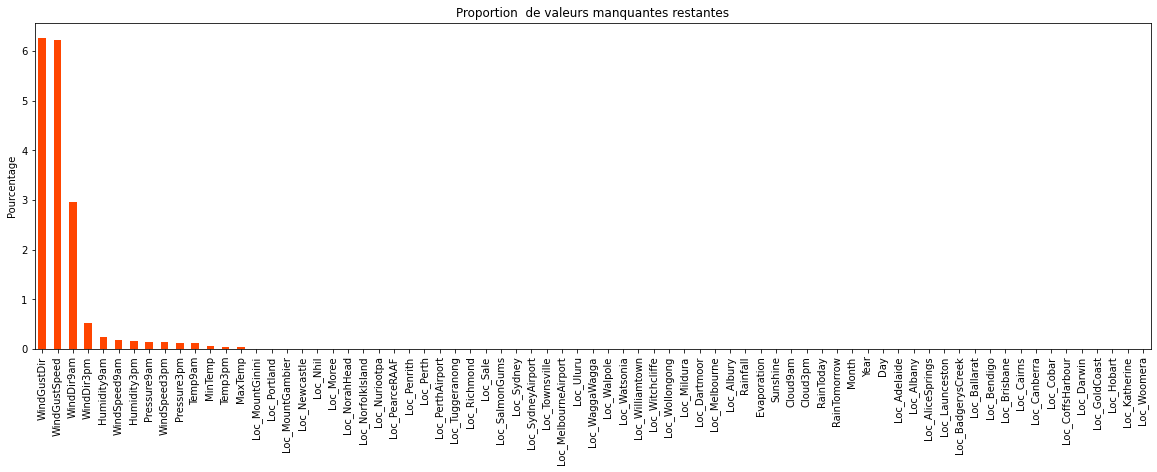

In [19]:
plt.figure(figsize=(20,6))
(df.isna().sum()/df.shape[0]*100).sort_values(ascending=False).plot.bar(title='Proportion  de valeurs manquantes restantes',
                                                                        ylabel='Pourcentage',
                                                                        rot=90,
                                                                        color='orangered');


In [20]:
# Remplacement des valeurs manquantes restantes par la valeur médiane de la variable

for var in X_train.columns :
  if X_train[var].isna().sum() !=0 :
    var_mediane = X_train[var].median()
    X_train[var] = X_train[var].fillna(var_mediane)

X_train.isna().sum().sum()

for var in X_test.columns :
  if X_test[var].isna().sum() !=0 :
    var_mediane = X_test[var].median()
    X_test[var] = X_test[var].fillna(var_mediane)


C:\Users\33661\AppData\Local\Temp/ipykernel_4012/3730769765.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[var] = X_train[var].fillna(var_mediane)
C:\Users\33661\AppData\Local\Temp/ipykernel_4012/3730769765.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[var] = X_test[var].fillna(var_mediane)


In [21]:
# Vérification qu'il n'y a plus de valeurs manquantes :

X_train.isna().sum().sum(), X_test.isna().sum().sum()


(0, 0)

##  **Traitement des outliers**


**Dans la partie exploratoire, nous avons identifé les outliers. Nous faisons le choix de remplacer les valeurs excessives c'est à dire soit inférieures à Q1 - 3IQR par Q1 - 3IQR  soit supérieures à Q3 + 3IQR) par Q3 + 3IQR.**

In [22]:
# Traitement des outliers identifiés dans la partie exploratoire dans les jeux d'entrainement et de test.

def val_max(df, var, max) :
  return np.where(df[var] > max, max, df[var])


X_train['Rainfall'] = val_max(X_train, 'Rainfall', 3.2)
X_train['Evaporation'] = val_max(X_train, 'Evaporation', 21.8)
X_train['WindGustSpeed'] = val_max(X_train, 'WindGustSpeed', 99)
X_train['WindSpeed9am'] = val_max(X_train, 'WindSpeed9am', 55)
X_train['WindSpeed3pm'] = val_max(X_train, 'WindSpeed3pm', 57)


X_test['Rainfall'] = val_max(X_test, 'Rainfall', 3.2)
X_test['Evaporation'] = val_max(X_test, 'Evaporation', 21.8)
X_test['WindGustSpeed'] = val_max(X_test, 'WindGustSpeed', 99)
X_test['WindSpeed9am'] = val_max(X_test, 'WindSpeed9am', 55)
X_test['WindSpeed3pm'] = val_max(X_test, 'WindSpeed3pm', 57)


C:\Users\33661\AppData\Local\Temp/ipykernel_4012/3251276533.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Rainfall'] = val_max(X_train, 'Rainfall', 3.2)
C:\Users\33661\AppData\Local\Temp/ipykernel_4012/3251276533.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Evaporation'] = val_max(X_train, 'Evaporation', 21.8)
C:\Users\33661\AppData\Local\Temp/ipykernel_4012/3251276533.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [23]:
X_train.describe()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Loc_Townsville,Loc_Tuggeranong,Loc_Uluru,Loc_WaggaWagga,Loc_Walpole,Loc_Watsonia,Loc_Williamtown,Loc_Witchcliffe,Loc_Wollongong,Loc_Woomera
count,49835.000000,49835.000000,49835.000000,49835.000000,49835.000000,4.983500e+04,49835.000000,4.983500e+04,4.983500e+04,49835.000000,...,49835.000000,49835.0,49835.0,49835.000000,49835.0,49835.000000,49835.000000,49835.0,49835.0,49835.000000
mean,13.317044,23.946987,0.681696,5.354137,7.650579,1.634892e-02,40.398756,4.097348e-02,1.445361e-02,15.083335,...,0.040273,0.0,0.0,0.040955,0.0,0.047918,0.021009,0.0,0.0,0.029076
std,6.364705,6.883777,1.186902,3.465901,3.767829,6.977090e-01,12.919650,6.970448e-01,7.187520e-01,8.605680,...,0.196601,0.0,0.0,0.198188,0.0,0.213595,0.143417,0.0,0.0,0.168021
min,-6.700000,4.100000,0.000000,0.000000,0.000000,-1.000000e+00,9.000000,-1.000000e+00,-1.000000e+00,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
25%,8.500000,18.600000,0.000000,2.800000,4.900000,-7.071068e-01,31.000000,-7.071068e-01,-7.071068e-01,9.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
50%,13.100000,23.400000,0.000000,4.800000,8.500000,6.123234e-17,39.000000,6.123234e-17,6.123234e-17,13.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
75%,18.100000,29.300000,0.800000,7.400000,10.700000,7.071068e-01,48.000000,7.071068e-01,7.071068e-01,20.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
max,31.400000,48.100000,3.200000,21.800000,14.500000,1.000000e+00,99.000000,1.000000e+00,1.000000e+00,55.000000,...,1.000000,0.0,0.0,1.000000,0.0,1.000000,1.000000,0.0,0.0,1.000000


In [24]:
X_test.describe()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Loc_Townsville,Loc_Tuggeranong,Loc_Uluru,Loc_WaggaWagga,Loc_Walpole,Loc_Watsonia,Loc_Williamtown,Loc_Witchcliffe,Loc_Wollongong,Loc_Woomera
count,12459.000000,12459.000000,12459.000000,12459.000000,12459.000000,1.245900e+04,12459.000000,1.245900e+04,1.245900e+04,12459.000000,...,12459.000000,12459.0,12459.0,12459.000000,12459.0,12459.000000,12459.000000,12459.0,12459.0,12459.000000
mean,13.334465,23.916462,0.683394,5.355037,7.636135,1.692286e-02,40.634401,4.452929e-02,1.891159e-02,15.198331,...,0.041496,0.0,0.0,0.041336,0.0,0.047917,0.019343,0.0,0.0,0.028333
std,6.404499,6.919572,1.185055,3.443357,3.748662,7.009400e-01,13.022696,6.970874e-01,7.212202e-01,8.640419,...,0.199443,0.0,0.0,0.199073,0.0,0.213600,0.137735,0.0,0.0,0.165929
min,-6.500000,7.000000,0.000000,0.000000,0.000000,-1.000000e+00,9.000000,-1.000000e+00,-1.000000e+00,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
25%,8.500000,18.400000,0.000000,2.600000,5.000000,-7.071068e-01,31.000000,-7.071068e-01,-7.071068e-01,9.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
50%,13.000000,23.500000,0.000000,4.800000,8.500000,6.123234e-17,39.000000,6.123234e-17,6.123234e-17,15.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
75%,18.200000,29.200000,0.800000,7.400000,10.600000,7.071068e-01,48.000000,7.071068e-01,7.071068e-01,20.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
max,30.500000,46.800000,3.200000,21.800000,14.100000,1.000000e+00,99.000000,1.000000e+00,1.000000e+00,55.000000,...,1.000000,0.0,0.0,1.000000,0.0,1.000000,1.000000,0.0,0.0,1.000000


## **Normalisation des données**

In [25]:
col = [X_train.columns]

scaler=preprocessing.StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns = col)
X_test = pd.DataFrame(X_test, columns = col)


In [26]:
X_train.head()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Loc_Townsville,Loc_Tuggeranong,Loc_Uluru,Loc_WaggaWagga,Loc_Walpole,Loc_Watsonia,Loc_Williamtown,Loc_Witchcliffe,Loc_Wollongong,Loc_Woomera
0,-2.013789,-1.677437,-0.574354,-1.140880,-0.703484,-1.456709,-0.572680,-1.073228,-1.411424,-0.009684,...,-0.204848,0.0,0.0,-0.20665,0.0,-0.224343,-0.146493,0.0,0.0,-0.173051
1,-0.458320,-1.270680,1.447736,-0.794646,-0.278832,-1.036912,0.278744,-1.384219,-1.305516,-0.939312,...,-0.204848,0.0,0.0,-0.20665,0.0,-0.224343,-0.146493,0.0,0.0,-0.173051
2,1.002878,0.632365,2.121766,0.186350,1.180910,-0.023433,-0.108267,-1.493425,1.371205,-1.287922,...,-0.204848,0.0,0.0,-0.20665,0.0,-0.224343,-0.146493,0.0,0.0,-0.173051
3,-0.615438,0.094864,-0.574354,-0.852352,0.676636,-0.023433,-0.727485,-0.058782,0.963698,1.036148,...,-0.204848,0.0,0.0,-0.20665,0.0,-0.224343,-0.146493,0.0,0.0,-0.173051
4,-1.542435,-1.459531,-0.574354,-1.083174,-0.331913,-0.023433,-1.424105,1.375860,-0.552542,-0.939312,...,-0.204848,0.0,0.0,-0.20665,0.0,4.457458,-0.146493,0.0,0.0,-0.173051


In [27]:
X_test.head()


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Loc_Townsville,Loc_Tuggeranong,Loc_Uluru,Loc_WaggaWagga,Loc_Walpole,Loc_Watsonia,Loc_Williamtown,Loc_Witchcliffe,Loc_Wollongong,Loc_Woomera
0,-0.741133,-1.183517,0.605199,-1.313997,-0.517698,-0.023433,-0.572680,-0.607796,-0.552542,0.222723,...,-0.204848,0.0,0.0,-0.20665,0.0,-0.224343,-0.146493,0.0,0.0,-0.173051
1,0.217287,-0.486219,-0.237339,-0.852352,-1.101595,-1.347608,0.743158,-1.384219,-1.305516,0.455130,...,-0.204848,0.0,0.0,-0.20665,0.0,-0.224343,-0.146493,0.0,0.0,-0.173051
2,1.222843,0.501621,0.605199,0.013233,-1.367002,0.525059,0.201342,0.490232,0.512323,-0.009684,...,-0.204848,0.0,0.0,-0.20665,0.0,-0.224343,-0.146493,0.0,0.0,-0.173051
3,1.615638,1.329663,-0.574354,-0.044473,1.021665,-1.347608,-0.572680,0.490232,-1.003917,-0.474498,...,-0.204848,0.0,0.0,-0.20665,0.0,-0.224343,-0.146493,0.0,0.0,-0.173051
4,-1.652418,-1.648383,-0.574354,-1.025469,-0.305372,1.300742,-1.269301,-0.058782,0.963698,-1.752736,...,-0.204848,0.0,0.0,-0.20665,0.0,-0.224343,-0.146493,0.0,0.0,-0.173051


# **8 Premières modélisations : Comparaison de plusieurs méthodes d'apprentissage - sans réglage d'hyper paramètre**


## **Regression Logistique**

In [ ]:
clf = linear_model.LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n\n Rapport de classification :\n",classification_report(y_test, y_pred))
pd.crosstab(y_test,y_pred, rownames=[' classe réelle'], colnames = ['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,




 Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      9647
           1       0.74      0.54      0.62      2812

    accuracy                           0.85     12459
   macro avg       0.81      0.74      0.77     12459
weighted avg       0.84      0.85      0.84     12459



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


classe predite,0,1
classe réelle,,
0,9102,545
1,1290,1522


## **SVM**

In [ ]:
clf=svm.SVC()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
pd.crosstab(y_test,y_pred, rownames=['classe réelle'], colnames=['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,




 Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      9647
           1       0.79      0.53      0.64      2812

    accuracy                           0.86     12459
   macro avg       0.83      0.74      0.78     12459
weighted avg       0.86      0.86      0.85     12459



classe predite,0,1
classe réelle,,
0,9259,388
1,1322,1490


## **KNN**

In [ ]:
clf=neighbors.KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
pd.crosstab(y_test,y_pred, rownames=['classe réelle'], colnames=['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,




 Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.93      0.90      9647
           1       0.68      0.48      0.57      2812

    accuracy                           0.83     12459
   macro avg       0.77      0.71      0.73     12459
weighted avg       0.82      0.83      0.82     12459



classe predite,0,1
classe réelle,,
0,9016,631
1,1449,1363


## **Decision Tree**

In [ ]:
clf= DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
pd.crosstab(y_test,y_pred, rownames=['classe réelle'], colnames=['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,




 Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.86      0.87      9647
           1       0.54      0.57      0.56      2812

    accuracy                           0.80     12459
   macro avg       0.71      0.71      0.71     12459
weighted avg       0.80      0.80      0.80     12459



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


classe predite,0,1
classe réelle,,
0,8311,1336
1,1215,1597


## **Random Forest**

In [ ]:
clf=ensemble.RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
pd.crosstab(y_test,y_pred, rownames=['classe réelle'], colnames=['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,




 Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.96      0.91      9647
           1       0.77      0.51      0.62      2812

    accuracy                           0.86     12459
   macro avg       0.82      0.74      0.76     12459
weighted avg       0.85      0.86      0.84     12459



classe predite,0,1
classe réelle,,
0,9218,429
1,1365,1447


# **9 Jeux déséquilibré - Rééquilibrage des classes avec RandomUnderSampler**

##  **Rééchantillonnage des jeux d'entrainement**

In [ ]:
# Le jeu étant déséquilibré (20% / 80% pour la cible 1 / 0), rééquilibrage des classes pour améliorer le rappel 1

from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import f1_score

rUs=RandomUnderSampler(random_state=28)
X_ru, y_ru = rUs.fit_resample(X_train,y_train)

print('\n y_ru : \n',y_ru.value_counts(), '\n')



 y_ru : 
 0    11097
1    11097
Name: RainTomorrow, dtype: int64 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


## R**egression Logistique**

In [ ]:
clf=linear_model.LogisticRegression()
clf.fit(X_ru, y_ru)
y_pred=clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
pd.crosstab(y_test,y_pred, rownames=['classe réelle'], colnames=['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,




 Rapport de classification :
               precision    recall  f1-score   support

           0       0.93      0.81      0.86      9647
           1       0.54      0.79      0.64      2812

    accuracy                           0.80     12459
   macro avg       0.74      0.80      0.75     12459
weighted avg       0.84      0.80      0.81     12459



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


classe predite,0,1
classe réelle,,
0,7795,1852
1,596,2216


## **SVM**

In [ ]:
clf=svm.SVC()
clf.fit(X_ru, y_ru)
y_pred=clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
pd.crosstab(y_test,y_pred, rownames=['classe réelle'], colnames=['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,




 Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.81      0.87      9647
           1       0.56      0.82      0.66      2812

    accuracy                           0.81     12459
   macro avg       0.75      0.81      0.77     12459
weighted avg       0.85      0.81      0.82     12459



classe predite,0,1
classe réelle,,
0,7795,1852
1,501,2311


## **KNN**

In [ ]:
clf=neighbors.KNeighborsClassifier()
clf.fit(X_ru, y_ru)
y_pred=clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
pd.crosstab(y_test,y_pred, rownames=['classe réelle'], colnames=['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,




 Rapport de classification :
               precision    recall  f1-score   support

           0       0.92      0.78      0.84      9647
           1       0.51      0.77      0.61      2812

    accuracy                           0.78     12459
   macro avg       0.71      0.77      0.73     12459
weighted avg       0.83      0.78      0.79     12459



classe predite,0,1
classe réelle,,
0,7528,2119
1,650,2162


## **Decision Tree**

In [ ]:
clf= DecisionTreeClassifier()
clf.fit(X_ru, y_ru)
y_pred=clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
pd.crosstab(y_test,y_pred, rownames=['classe réelle'], colnames=['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,




 Rapport de classification :
               precision    recall  f1-score   support

           0       0.90      0.73      0.81      9647
           1       0.44      0.73      0.55      2812

    accuracy                           0.73     12459
   macro avg       0.67      0.73      0.68     12459
weighted avg       0.80      0.73      0.75     12459



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


classe predite,0,1
classe réelle,,
0,7037,2610
1,770,2042


## **random Forest**

In [ ]:
clf=ensemble.RandomForestClassifier(n_jobs=-1)
clf.fit(X_ru, y_ru)
y_pred=clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
pd.crosstab(y_test,y_pred, rownames=['classe réelle'], colnames=['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,




 Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.80      0.86      9647
           1       0.54      0.82      0.66      2812

    accuracy                           0.80     12459
   macro avg       0.74      0.81      0.76     12459
weighted avg       0.85      0.80      0.82     12459



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


classe predite,0,1
classe réelle,,
0,7718,1929
1,503,2309


# **10 Règlages d'hyper paramètres sur le jeu rééquilibré**




## **HP Regression Logistique**


In [ ]:
clf=linear_model.LogisticRegression()
parameters = {'penalty' : ['l1', 'l2'], 'C' : [0.1, 1, 10, 100]}
            
grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_ru, y_ru)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters Logistic Regression : ",grid_clf.best_params_)
pd.crosstab(y_test, y_pred, rownames=['classe réelle'], colnames=['classe prédite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.93      0.81      0.86      9647
           1       0.54      0.79      0.64      2812

    accuracy                           0.80     12459
   macro avg       0.74      0.80      0.75     12459
weighted avg       0.84      0.80      0.81     12459

best parameters Logistic Regression :  {'C': 0.1, 'penalty': 'l2'}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


classe prédite,0,1
classe réelle,,
0,7790,1857
1,590,2222


## **HP SVM**





In [ ]:
# réglage avec recherche sur grille (en plusieurs fois car problème de capacité CPU)

clf = svm.SVC()
parameters = {'C' : [1, 5], 'gamma' : [0.1, 0.01, 0.001],'kernel' : ['rbf']}
              
grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_ru, y_ru)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters SVM : ",grid_clf.best_params_)
pd.crosstab(y_test, y_pred, rownames=['classe réelle'], colnames=['classe prédite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.81      0.87      9647
           1       0.56      0.82      0.66      2812

    accuracy                           0.81     12459
   macro avg       0.75      0.82      0.77     12459
weighted avg       0.85      0.81      0.82     12459

best parameters SVM :  {'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}


classe prédite,0,1
classe réelle,,
0,7830,1817
1,507,2305


In [ ]:
clf = svm.SVC()
parameters = {'C' : [7, 10], 'gamma' : [0.1, 0.01, 0.001],'kernel' : ['rbf']}
              
grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_ru, y_ru)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters SVM : ",grid_clf.best_params_)
pd.crosstab(y_test, y_pred, rownames=['classe réelle'], colnames=['classe prédite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.81      0.87      9647
           1       0.56      0.82      0.67      2812

    accuracy                           0.82     12459
   macro avg       0.75      0.82      0.77     12459
weighted avg       0.85      0.82      0.83     12459

best parameters SVM :  {'C': 7, 'gamma': 0.01, 'kernel': 'rbf'}


classe prédite,0,1
classe réelle,,
0,7859,1788
1,506,2306


In [ ]:
clf = svm.SVC()
parameters = {'C' : [1, 5], 'gamma' : [0.1, 0.01, 0.001],'kernel' : ['sigmoid']}
  
grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_ru, y_ru)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters SVM : ",grid_clf.best_params_)
pd.crosstab(y_test, y_pred, rownames=['classe réelle'], colnames=['classe prédite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.93      0.80      0.86      9647
           1       0.54      0.80      0.64      2812

    accuracy                           0.80     12459
   macro avg       0.73      0.80      0.75     12459
weighted avg       0.84      0.80      0.81     12459

best parameters SVM :  {'C': 5, 'gamma': 0.001, 'kernel': 'sigmoid'}


classe prédite,0,1
classe réelle,,
0,7728,1919
1,573,2239


In [ ]:
clf = svm.SVC()
parameters = {'C' : [7, 10], 'gamma' : [0.1, 0.01, 0.001],'kernel' : ['sigmoid']}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_ru, y_ru)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters SVM : ",grid_clf.best_params_)
pd.crosstab(y_test, y_pred, rownames=['classe réelle'], colnames=['classe prédite'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.93      0.80      0.86      9647
           1       0.54      0.80      0.64      2812

    accuracy                           0.80     12459
   macro avg       0.74      0.80      0.75     12459
weighted avg       0.84      0.80      0.81     12459

best parameters SVM :  {'C': 7, 'gamma': 0.001, 'kernel': 'sigmoid'}


classe prédite,0,1
classe réelle,,
0,7737,1910
1,573,2239



## **HP KNN**

In [ ]:
clf = neighbors.KNeighborsClassifier()
parameters = {'n_neighbors': [3, 5, 8, 13, 19], 'weights' : ['uniform', 'distance'],'metric' : ['euclidean', 'manattan']}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_ru, y_ru)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters KNN : ",grid_clf.best_params_)
pd.crosstab(y_test, y_pred, rownames=['classe réelle'], colnames=['classe prédite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.93      0.80      0.86      9647
           1       0.53      0.78      0.63      2812

    accuracy                           0.79     12459
   macro avg       0.73      0.79      0.74     12459
weighted avg       0.84      0.79      0.80     12459

best parameters KNN :  {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'distance'}


classe prédite,0,1
classe réelle,,
0,7678,1969
1,618,2194


## **HP Decision Tree**

In [ ]:
clf = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth': range(1,10)}
              
grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_ru, y_ru)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters Decision Tree : ", grid_clf.best_params_)
pd.crosstab(y_test, y_pred, rownames=['classe réelle'], colnames=['classe prédite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.93      0.75      0.83      9647
           1       0.48      0.81      0.60      2812

    accuracy                           0.76     12459
   macro avg       0.71      0.78      0.72     12459
weighted avg       0.83      0.76      0.78     12459

best parameters Decision Tree :  {'criterion': 'entropy', 'max_depth': 6}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


classe prédite,0,1
classe réelle,,
0,7215,2432
1,546,2266


## **HP Random Forest**


In [ ]:
clf=ensemble.RandomForestClassifier()
parameters = {'criterion': ["gini",'entropy'], 'max_features': ["sqrt", "log2"], 'min_samples_split': range(2, 10, 2)}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid=parameters)
grid_clf.fit(X_ru, y_ru)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parametersRandom Forest : ",grid_clf.best_params_)
pd.crosstab(y_test, y_pred, rownames=['classe réelle'], colnames=['classe prédite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.80      0.86      9647
           1       0.55      0.82      0.65      2812

    accuracy                           0.81     12459
   macro avg       0.74      0.81      0.76     12459
weighted avg       0.85      0.81      0.82     12459

best parametersRandom Forest :  {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 2}


classe prédite,0,1
classe réelle,,
0,7727,1920
1,509,2303


# **11 Règlages d'hyper paramètres sur jeu non rééquiibré**

## **HP Regression Logistique**

In [ ]:
clf = linear_model.LogisticRegression()
parameters = {'penalty' : ['l1', 'l2'], 'C' : [0.1, 1, 10, 100]}
       
grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters Logistic Regression : ",grid_clf.best_params_)
pd.crosstab(y_test,y_pred, rownames=[' classe réelle'], colnames = ['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      9647
           1       0.74      0.54      0.62      2812

    accuracy                           0.85     12459
   macro avg       0.81      0.74      0.77     12459
weighted avg       0.84      0.85      0.84     12459

best parameters Logistic Regression :  {'C': 1, 'penalty': 'l2'}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


classe predite,0,1
classe réelle,,
0,9102,545
1,1290,1522


## **HP SVM**

In [ ]:
# réglage avec recherche sur grille (en plusieurs fois car problème de capacité CPU)

clf = svm.SVC()
parameters = {'C' : [1, 5],  'gamma' : [0.1], 'kernel' : ['rbf']}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters SVM : ",grid_clf.best_params_)
pd.crosstab(y_test,y_pred, rownames=[' classe réelle'], colnames = ['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      9647
           1       0.76      0.52      0.62      2812

    accuracy                           0.86     12459
   macro avg       0.82      0.74      0.77     12459
weighted avg       0.85      0.86      0.85     12459

best parameters SVM :  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


classe predite,0,1
classe réelle,,
0,9190,457
1,1338,1474


In [ ]:
clf = svm.SVC()
parameters = {'C' : [1, 5], 'gamma' : [0.01],'kernel' : ['rbf']}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters SVM : ",grid_clf.best_params_)
pd.crosstab(y_test,y_pred, rownames=[' classe réelle'], colnames = ['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      9647
           1       0.79      0.54      0.64      2812

    accuracy                           0.86     12459
   macro avg       0.83      0.75      0.78     12459
weighted avg       0.86      0.86      0.85     12459

best parameters SVM :  {'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}


classe predite,0,1
classe réelle,,
0,9248,399
1,1294,1518


In [ ]:
clf = svm.SVC()
parameters = {'C' : [1, 5], 'gamma' : [0.001],'kernel' : ['rbf']}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters SVM : ",grid_clf.best_params_)
pd.crosstab(y_test,y_pred, rownames=[' classe réelle'], colnames = ['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.96      0.91      9647
           1       0.78      0.50      0.61      2812

    accuracy                           0.86     12459
   macro avg       0.83      0.73      0.76     12459
weighted avg       0.85      0.86      0.84     12459

best parameters SVM :  {'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}


classe predite,0,1
classe réelle,,
0,9257,390
1,1405,1407


In [ ]:
clf = svm.SVC()
parameters = {'C' : [7, 10], 'gamma' : [0.1],'kernel' : ['rbf']}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters SVM : ",grid_clf.best_params_)
pd.crosstab(y_test,y_pred, rownames=[' classe réelle'], colnames = ['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      9647
           1       0.67      0.57      0.62      2812

    accuracy                           0.84     12459
   macro avg       0.78      0.74      0.76     12459
weighted avg       0.83      0.84      0.84     12459

best parameters SVM :  {'C': 7, 'gamma': 0.1, 'kernel': 'rbf'}


classe predite,0,1
classe réelle,,
0,8865,782
1,1208,1604


In [ ]:
clf = svm.SVC()
parameters = {'C' : [7, 10], 'gamma' : [0.01],'kernel' : ['rbf']}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters SVM : ",grid_clf.best_params_)
pd.crosstab(y_test,y_pred, rownames=[' classe réelle'], colnames = ['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      9647
           1       0.79      0.55      0.65      2812

    accuracy                           0.87     12459
   macro avg       0.83      0.75      0.78     12459
weighted avg       0.86      0.87      0.86     12459

best parameters SVM :  {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


classe predite,0,1
classe réelle,,
0,9228,419
1,1257,1555


In [ ]:
clf = svm.SVC()
parameters = {'C' : [7, 10], 'gamma' : [0.001],'kernel' : ['rbf']}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
pd.crosstab(y_test,y_pred, rownames=[' classe réelle'], colnames = ['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.96      0.91      9647
           1       0.78      0.51      0.62      2812

    accuracy                           0.86     12459
   macro avg       0.83      0.73      0.76     12459
weighted avg       0.85      0.86      0.85     12459



classe predite,0,1
classe réelle,,
0,9254,393
1,1384,1428


In [ ]:
clf = svm.SVC()
parameters = {'C' : [1, 5], 'gamma' : [0.1], 'kernel' : ["sigmoid"]}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters SVM : ",grid_clf.best_params_)
pd.crosstab(y_test,y_pred, rownames=[' classe réelle'], colnames = ['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      9647
           1       0.44      0.43      0.44      2812

    accuracy                           0.75     12459
   macro avg       0.64      0.64      0.64     12459
weighted avg       0.75      0.75      0.75     12459

best parameters SVM :  {'C': 1, 'gamma': 0.1, 'kernel': 'sigmoid'}


classe predite,0,1
classe réelle,,
0,8098,1549
1,1591,1221


In [ ]:
clf = svm.SVC()
parameters = {'C' : [1, 5], 'gamma' : [0.01], 'kernel' : ["sigmoid"]}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters SVM : ",grid_clf.best_params_)
pd.crosstab(y_test,y_pred, rownames=[' classe réelle'], colnames = ['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      9647
           1       0.54      0.49      0.51      2812

    accuracy                           0.79     12459
   macro avg       0.70      0.68      0.69     12459
weighted avg       0.78      0.79      0.79     12459

best parameters SVM :  {'C': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}


classe predite,0,1
classe réelle,,
0,8493,1154
1,1441,1371


In [ ]:
clf = svm.SVC()
parameters = {'C' : [1, 5], 'gamma' : [0.01], 'kernel' : ["sigmoid"]}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters SVM : ",grid_clf.best_params_)
pd.crosstab(y_test,y_pred, rownames=[' classe réelle'], colnames = ['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      9647
           1       0.54      0.49      0.51      2812

    accuracy                           0.79     12459
   macro avg       0.70      0.68      0.69     12459
weighted avg       0.78      0.79      0.79     12459

best parameters SVM :  {'C': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}


classe predite,0,1
classe réelle,,
0,8493,1154
1,1441,1371


In [ ]:
clf = svm.SVC()
parameters = {'C' : [7, 10], 'gamma' : [0.1],'kernel' : ["sigmoid"]}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters SVM : ",grid_clf.best_params_)
pd.crosstab(y_test,y_pred, rownames=[' classe réelle'], colnames = ['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      9647
           1       0.44      0.43      0.44      2812

    accuracy                           0.75     12459
   macro avg       0.64      0.64      0.64     12459
weighted avg       0.75      0.75      0.75     12459

best parameters SVM :  {'C': 7, 'gamma': 0.1, 'kernel': 'sigmoid'}


classe predite,0,1
classe réelle,,
0,8094,1553
1,1591,1221


In [ ]:
clf = svm.SVC()
parameters = {'C' : [7, 10], 'gamma' : [0.01],'kernel' : ["sigmoid"]}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters SVM : ",grid_clf.best_params_)
pd.crosstab(y_test,y_pred, rownames=[' classe réelle'], colnames = ['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      9647
           1       0.51      0.50      0.50      2812

    accuracy                           0.78     12459
   macro avg       0.68      0.68      0.68     12459
weighted avg       0.78      0.78      0.78     12459

best parameters SVM :  {'C': 7, 'gamma': 0.01, 'kernel': 'sigmoid'}


classe predite,0,1
classe réelle,,
0,8289,1358
1,1419,1393


In [ ]:
clf = svm.SVC()
parameters = {'C' : [7, 10], 'gamma' : [0.001], 'kernel' : ["sigmoid"]}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters SVM : ",grid_clf.best_params_)
pd.crosstab(y_test,y_pred, rownames=[' classe réelle'], colnames = ['classe predite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      9647
           1       0.76      0.51      0.61      2812

    accuracy                           0.85     12459
   macro avg       0.81      0.73      0.76     12459
weighted avg       0.84      0.85      0.84     12459

best parameters SVM :  {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}


classe predite,0,1
classe réelle,,
0,9194,453
1,1386,1426


## **HP KNN**

In [ ]:
clf = neighbors.KNeighborsClassifier()
parameters = {'n_neighbors': [3, 5, 8, 13, 19], 'weights' : ['uniform', 'distance'],'metric' : ['euclidean', 'manattan']}
              
grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters KNN : ",grid_clf.best_params_)
pd.crosstab(y_test, y_pred, rownames=['classe réelle'], colnames=['classe prédite'])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.86      0.96      0.90      9647
           1       0.75      0.45      0.57      2812

    accuracy                           0.84     12459
   macro avg       0.80      0.70      0.73     12459
weighted avg       0.83      0.84      0.83     12459

best parameters KNN :  {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'distance'}


classe prédite,0,1
classe réelle,,
0,9220,427
1,1535,1277


## **HP Decision Tree**

In [ ]:
clf = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth': range(1,10)}
              
grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid = parameters)
grid_clf.fit(X_train, y_train)
y_pred = grid_clf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parameters Decision Tree : ",grid_clf.best_params_)
pd.crosstab(y_test, y_pred, rownames=['classe réelle'], colnames=['classe prédite'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      9647
           1       0.72      0.50      0.59      2812

    accuracy                           0.84     12459
   macro avg       0.79      0.72      0.75     12459
weighted avg       0.83      0.84      0.83     12459

best parameters Decision Tree :  {'criterion': 'entropy', 'max_depth': 7}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


classe prédite,0,1
classe réelle,,
0,9091,556
1,1401,1411


## **HP Random Forest**

In [ ]:
clf = ensemble.RandomForestClassifier()
parameters = {'criterion': ["gini",'entropy'], 'max_features': ["sqrt", "log2"], 'min_samples_split': range(2, 10, 2)}

grid_rf = model_selection.GridSearchCV(estimator=clf, param_grid=parameters)
grid_rf.fit(X_train, y_train)
y_pred = grid_rf.predict(X_test)

print("\n\n Rapport de classification :\n", classification_report(y_test, y_pred))
print("best parametersRandom Forest : ",grid_rf.best_params_)
pd.crosstab(y_test, y_pred, rownames=['classe réelle'], colnames=['classe prédite'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.



 Rapport de classification :
               precision    recall  f1-score   support

           0       0.87      0.96      0.91      9647
           1       0.78      0.52      0.63      2812

    accuracy                           0.86     12459
   macro avg       0.83      0.74      0.77     12459
weighted avg       0.85      0.86      0.85     12459

best parametersRandom Forest :  {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2}


classe prédite,0,1
classe réelle,,
0,9237,410
1,1347,1465


# **12. Conclusion**

**- Lorsque l’on privilégie une précision  élevée pour la classe 1 ‘il pleut demain’ (au détriment du rappel)  le modèle avec les meilleures performances est le modèle SVM avec comme hyperparamètres :**

{'C' : 10, 'gamma' : 0.01, 'kernel' : 'rbf'} et entrainé sur jeu avec classes non rééquilibrées.

**ACCURACY = 0.87 et PRECISION 0.79**




**- Lorsque l’on privilégie un rappel élevé pour la classe 1 ‘il pleut demain’ le modèle avec les meilleures performances est le modèle SVM avec comme hyperparamètres :**
 {'C': 7, 'gamma': 0.01, 'kernel': 'rbf'} et entrainé sur classes rééquilibrées.

**ACCURACY = 0.82 et RAPPEL 0.82**

